# Пайплайн обучения в PyTorch
В этой тетрадке мы соберем полный пайплайн обучения классификатора на основе нейросети.
На примере небольшого датасета мы увидим, как строить и обучать модели в PyTorch, и закрепим наши знания про слои.
## Классификация картинок
Задачу классификации будем решать по уже знакомому пайплайну:
- постановка задачи;
- определимся с метриками;
- соберем данные;
- построим бейзлайн, обучим его;
- проверим качество бейзлайна;

Бейзлайн мы построим на известных нам слоях: Linear и нелинейности.

### Постановка задачи и метрики
Требуется научиться классифицировать изображения английских букв от A до J.
Изображения имеют фиксированный размер 28x28 пикселей, черно-белые.

В качестве финальной метрики бизнес интересует **accuracy** - точность распознавания класса.

### Данные
Для обучения и валидации будем использовать датасет [notMNIST](https://www.kaggle.com/datasets/lubaroli/notmnist), который можно скачать по [ссылке](http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz).

#### Как хранятся картинки в памяти компьютера
Компьютер хранит картинку в памяти как набор точек (_пикселей_).
Каждый пиксель - это квадрат одного цвета.
Пиксели достаточно маленькие, поэтому глаз не замечает, что изображение состоит из квадратов.

В черно-белых изображениях пиксель представляет из себя одно чило - интенсивность белого цвета. 0 - это черный цвет, 255 - белый, посередине - оттенки серого.

В цветных изображениях пиксель - это набор из трех чисел: (R, G, B). R - интенсивность красного цвета, G - интенсивность зелёного цвета, B - синего.
Числа тоже в диапазоне от 0 до 255 (обычно).

В нашем датасете только ч/б изображения, поэтому каждая картинка будет представлять из себя матрицу (28, 28) - 28 пикселей в ширину и 28 в высоту.

In [1]:
import http.client
import tarfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

# Зафиксируем все seed для воспроизводимости
seed = 0
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
def prepare_data():
    """Скачивает данные и распаковывает их."""
    target_file = "notMNIST_small.tar.gz"
    if Path(target_file).exists() or Path("notMNIST_small").exists():
        print("Файл уже загружен, не загружаю снова")
    else:
        conn = http.client.HTTPConnection("yaroslavvb.com", 80)
        conn.request("GET", "/upload/notMNIST/notMNIST_small.tar.gz")
        data = conn.getresponse().read()
        with open(target_file, "wb") as f:
            f.write(data)
        with tarfile.open(target_file) as f:
            f.extractall()
    print("Данные были скачены и распакованы")


def read_notmnist_data(
    data_dir: str = "notMNIST_small",
) -> tuple[np.ndarray, np.ndarray]:
    """Прочитать картинки датасета notMNIST и положить их в numpy-массив.

    :returns: пару numpy-массивов (изображения, соответствующие метки)
    """
    images, labels = [], []
    for img_path in Path(data_dir).glob("**/*.png"):
        # Имя папки - это метка класса
        img_label = img_path.parts[1]
        try:
            image = plt.imread(img_path)
        except SyntaxError:
            print(
                f"Изображение не читается по пути {img_path} (это ок, но таких должно быть < 10)"
            )
            continue
        labels.append(img_label)
        images.append(image)
    return np.stack(images, axis=0), np.stack(labels, axis=0)


prepare_data()
X, y = read_notmnist_data()
assert X.shape[0] == y.shape[0]
print()
print("Размеры данных:", X.shape, y.shape)
print(f"Пример класса: {y[0]}")
# видим, что метки - это буквы, закодируем их числами
ohe = LabelEncoder()
y = ohe.fit_transform(y)

Файл уже загружен, не загружаю снова
Данные были скачены и распакованы
Изображение не читается по пути notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png (это ок, но таких должно быть < 10)
Изображение не читается по пути notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png (это ок, но таких должно быть < 10)

Размеры данных: (18724, 28, 28) (18724,)
Пример класса: A


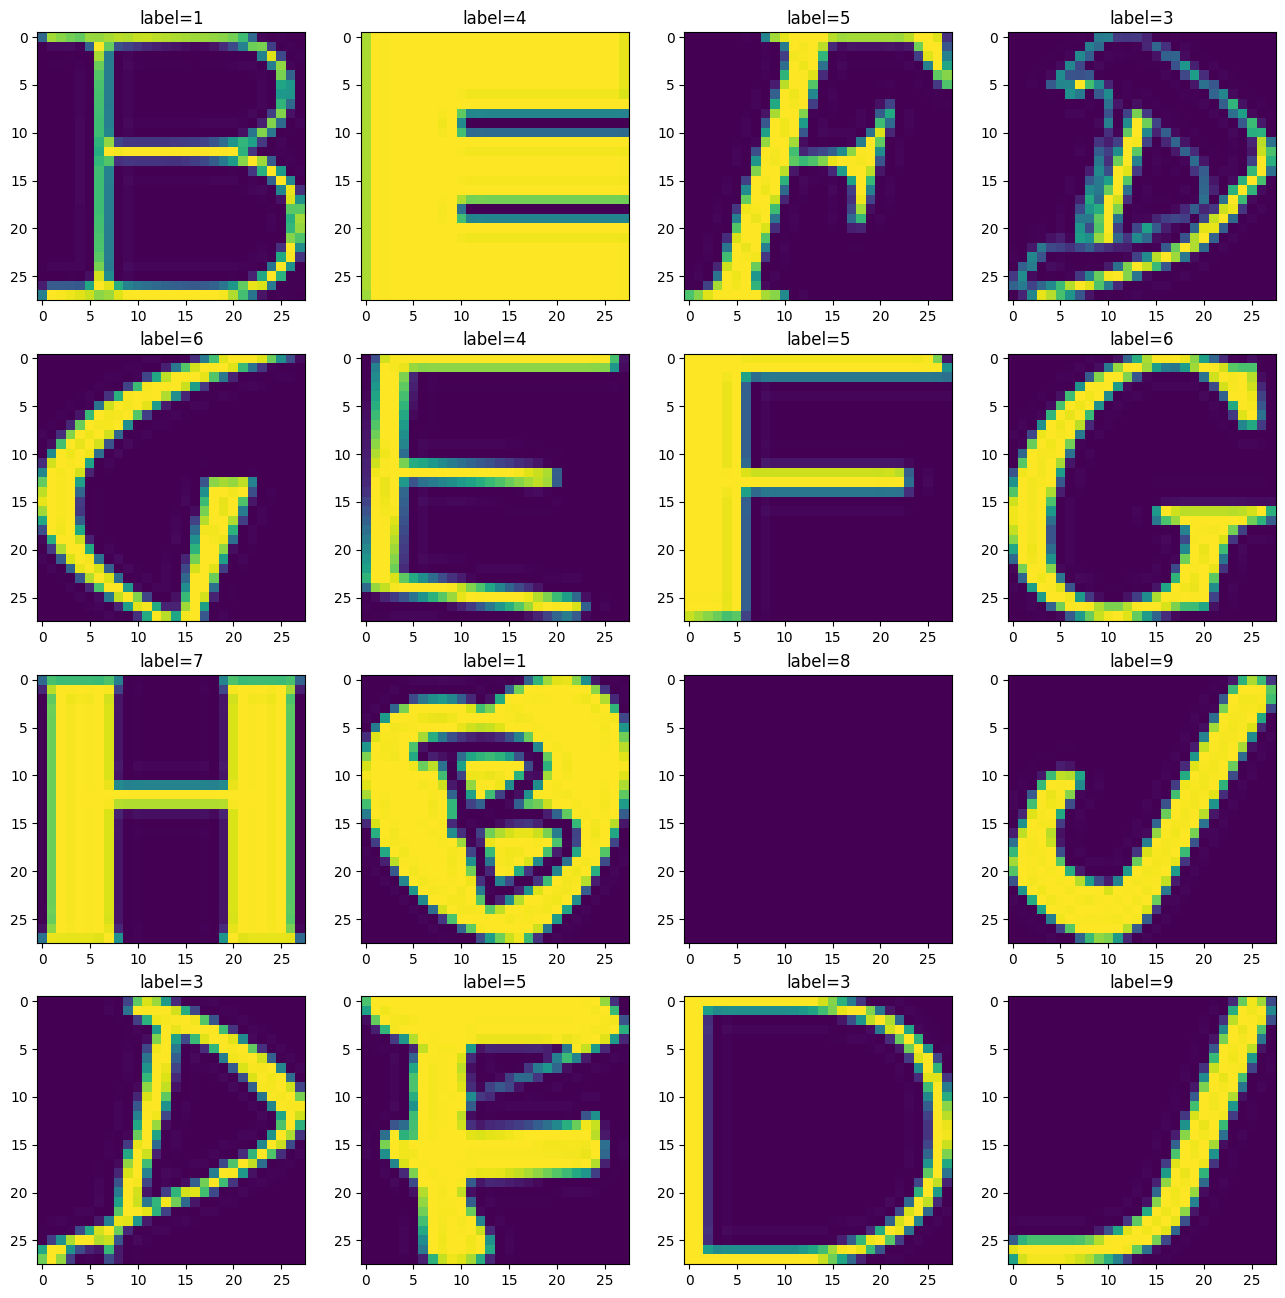

In [5]:
# Данных много, можно поделить на train/val/test
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=seed
)
# Посмотрим на данные глазами
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for row in range(4):
    for col in range(4):
        idx = 4 * row + col
        ax[row][col].imshow(X_train[idx])
        ax[row][col].set_title(f"label={y_train[idx]}")

### Строим бейзлайн
В качестве простой модели попробуем несколько линейных слоев и нелинейностей.
#### Создаем модель

In [6]:
# Нейросети объявляются через класс, который наследуется от torch.nn.Module
# Внутри класса нужно реализовать метод forward: в нем прописано, что сеть делает с тензором
class SimpleModel(nn.Module):
    # В __init__ объявим все слои, которые нам нужны
    def __init__(self, num_classes: int):
        super().__init__()

        # NOTE: Linear принимает (N, C), картинки заданы как (N, W, H) - придется менять форму, держим в уме.
        # Будем из 28 * 28 переводить в 256
        hidden_dim = 256
        self.linear_1 = nn.Linear(in_features=28 * 28, out_features=hidden_dim)

        # Нелинейность иногда называют активацией. Мы возьмем ReLU(x) = max(x, 0)
        self.act_1 = nn.ReLU()

        # Второй линейный слой, принимать будет выход из первого
        self.linear_2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)

        # Softmax выдает числа от 0 до 1, которые в сумме дают 1 - идеально для классификации
        self.act_2 = nn.Softmax(dim=1)
        # NOTE: какой выход куда пойдет - это будет прописано в forward

    def forward(self, x: torch.Tensor):
        # В этом методе нужно сделать все преобразования над тензором.
        # Мы сначала поменяем форму, как это требует linear_1
        x = x.reshape((-1, 28 * 28))
        # Потом последовательно применим все слои
        for one_transform in (self.linear_1, self.act_1, self.linear_2, self.act_2):
            x = one_transform(x)
        # x = self.linear_1(x)
        # x = self.act_1(x)
        # x = self.linear_2(x)
        # x = self.act_1(x)
        return x


# Полезно всегда проверить, что сеть может прогнать ваши данные.
model = SimpleModel(num_classes=len(ohe.classes_))
# PyTorch модели не умеют работать с numpy-массивами, только с torch.Tensor.
# Конвертируем через torch.from_numpy
some_output = model(torch.from_numpy(X_train[[0]]))
some_output

tensor([[0.1073, 0.0971, 0.1000, 0.1007, 0.0931, 0.0828, 0.1031, 0.1084, 0.1059,
         0.1016]], grad_fn=<SoftmaxBackward0>)

Таким образом, чтобы объявить сеть в PyTorch, нужно:
- создать класс, наследующийся от `nn.Module`;
- в методе `forward(self, x)` прописать, сколько тензоров сеть принимает и что с ними нужно сделать;
- в конструкторе (метод `__init__`) объявить все необходимые слои, вызвав `super().__init__()` в начале;

Желательно также прогнать созданную сеть над примером данных - чтобы убедиться, что все работает.

##### Про градиент
Обратите внимание: у выхода сети есть `grad_fn`.
Это неспроста: мы использовали все слои из `torch.nn`, поэтому PyTorch сумел **самостоятельно** разобраться, как считать градиент по всем слоям и всем параметрам.
Нам не нужно расписывать формулы и считать градиенты - это делает автоматика!

In [7]:
# Давайте убедимся в этом: подсчитаем функцию потерь и попросим от нее градиент.
# Будем использовать Cross Entropy в качестве функции потерь - хороший вариант для задачи классификации.
import torch.nn.functional as F

loss = F.cross_entropy(some_output, torch.from_numpy(y[[0]]))
print(loss)
# Хм, а реально ли градиенты все сами подсчитаются? Посмотрим
print(model.linear_1.weight.grad)
# Градиента нет - мы лишь прогнали данные через модель

tensor(2.2953, grad_fn=<NllLossBackward0>)
None


In [8]:
# Теперь просим подсчитать градиент и распространить его назад по всем слоям
loss.backward()
# Смотрим на градиент
print(model.linear_1.weight.grad)

tensor([[ 3.6360e-04,  9.4109e-04,  8.9831e-04,  ...,  8.5554e-06,
          4.2777e-06,  0.0000e+00],
        [-5.6978e-04, -1.4747e-03, -1.4077e-03,  ..., -1.3407e-05,
         -6.7033e-06, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 2.3845e-03,  6.1718e-03,  5.8912e-03,  ...,  5.6107e-05,
          2.8053e-05,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.1184e-03,  5.4829e-03,  5.2337e-03,  ...,  4.9845e-05,
          2.4922e-05,  0.0000e+00]])


Градиент появился. Когда мы вызвали `loss.backward()`, PyTorch сделал сделал следующее:
1. Подсчитал напрямую производую лосса $L = -\sum\limits_{c=1}^M y_c \log p_c$ по $p_c$.
2. Отследил цепочку преобразований, через которую получился этот $p_c$ - вероятность каждого класса.
3. Прошелся по этой цепочке с конца в начало, применил chain rule и подсчитал градиент по каждому из обучаемых параметров.
4. Записал этот градиент в тензоры weight и bias каждого слоя, чтобы не забыть.

И все это произошло "под капотом" одной функции: `loss.backward()` - чудеса!

#### Обучаем модель
Окей, мы собрали данные, построили модель, выбрали функцию потерь, научились считать градиент по всем параметрам модели.
Дело осталось за малым - пройтись градиентным спуском по данным и оптимизировать параметры.

PyTorch делает четкое разделение: модели в одном месте, алгоритм спуска - в другом.
Более того, сам спуск вам понадобится написать вручную - не бойтесь, это несложно.

In [9]:
# Преобразуем все данные в torch.Tensor, чтобы не вызывать везде torch.from_numpy
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_val, y_val = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

In [10]:
import tqdm

# все методы оптимизации лежат в torch.optim
from torch.optim.sgd import SGD

"""
Для "обучения" модели есть модуль torch.optim - в нем инструменты для обучения параметров.
Сегодня мы будем использовать Стохастический Градиентный Спуск - Stohastic Gradient Descent.
Стохастичности у нас не будет: мы "скормим" все данные модели сразу (они маленькие, это сработает).

Optimizer работает так:
- вы говорите ему, какие параметры в его зоне ответственности;
- затем вы говорите ему, что пришло время сделать шаг спуска;
- optimizer проходит по всем параметрам, за которые отвечает, берет их градиент и что-то с ним делает;
- что именно делает - зависит от конкретного оптимизатора;

Конкретно SGD делает обновление весов по формуле w <- w - eta * gradient.
Это обычный градиентный спуск.
Есть более продвинутые алгоритмы (Adam, RMSprop), с ними познакомимся позже.
"""
# создаем optimizer и говорим "ты отвечаешь за все параметры модели"
optimizer = SGD(params=model.parameters(), lr=1e-1)
# model.parameters() возвращает все обучаемые параметры модели (в виде тензоров).
# Откуда функция все эти параметры узнает, ведь мы нигде их явно не прописывали в классе модели?
# Это магия PyTorch, он умеет многое делать сам :)


def train_model(model: nn.Module, optimizer: SGD, x: torch.Tensor, y: torch.Tensor):
    losses = []
    # Пройдемся 2000 раз по всем данным
    for _ in tqdm.trange(2_000):
        # optimizer по умолчанию "помнит" градиенты с прошлых итераций - и прибавляет к новым.
        # Так сделано ради продвинутых техник обучения.
        # Нам это не надо, поэтому в каждой итерации явно зануляем все градиенты - пусть считаются заново.
        optimizer.zero_grad()

        # Это блок уже знаем: считаем выход, потери, градиенты по потерям.
        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()

        # Просим оптимизатор пройтись по параметрам и сделать градиентный спуск.
        # Оптимизатор сам обновит веса, вручную этого делать не надо
        optimizer.step()

        # Запомним loss
        losses.append(loss.detach().item())
    return losses


losses = train_model(model, optimizer, X_train, y_train)

d:\Github\Karpov.courses_DL\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2000/2000 [04:34<00:00,  7.28it/s]


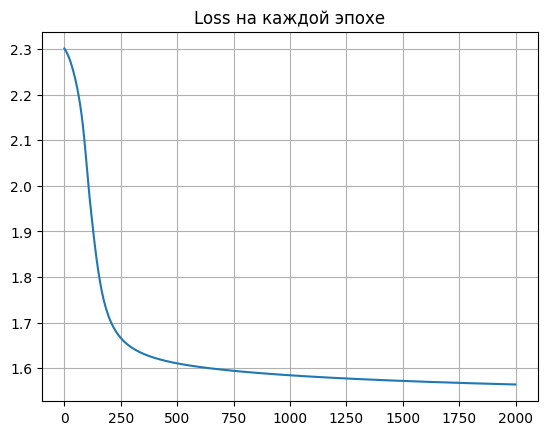

In [11]:
# Посмотрим, действительно ли модель училась
def plot_losses(losses: list[float]):
    plt.plot(losses)
    plt.title("Loss на каждой эпохе")
    plt.grid()
    plt.show()


plot_losses(losses)

In [12]:
# А что по качеству?
def accuracy(model: SimpleModel, x: torch.Tensor, y: torch.Tensor):
    return torch.sum(torch.argmax(model(x), dim=1) == y) / len(y)


print(f"accuracy на train данных: {accuracy(model, X_train, y_train)}")
print(f"accuracy на val данных: {accuracy(model, X_val, y_val)}")
print(f"accuracy на test данных: {accuracy(model, X_test, y_test)}")

accuracy на train данных: 0.9080364108085632
accuracy на val данных: 0.8961949348449707
accuracy на test данных: 0.9036048054695129


Получилось весьма неплохо.

В нашем решении есть большой простор для улучшений:
- использовать AdaM вместо SGD;
- добавить больше слоев;
- попробовать новые слои (в следующем уроке пополним наш арсенал);

Как грамотно попробовать идеи и не потерять рабочий результат - узнаем на следующем уроке.

#### Резюме
1. Узнали, что картинки хранятся в компьютере как матрица, каждый ее элемент описывает интенсивность цвета.
2. Научились создавать нейросеть через класс, наследующийся от `nn.Module`.
3. Научились прогонять данные через нейросеть, считать функцию потерь и градиенты по всем параметрам.
4. Познакомились с оптимизаторами (_optimizer_), с их помощью обучили нейросеть, используя SGD.
5. Посчитали метрику качества обученной модели, получили рабочий бейзлайн.

### me: 

#### Необходимо как-то сохранять прогресс. Сохраним нашу модель, чтобы затем уметь загружать ее.

In [ ]:
model.state_dict()  ## обученные параметры модели

OrderedDict([('linear_1.weight',
              tensor([[ 0.0014,  0.0214, -0.0284,  ...,  0.0297,  0.0133,  0.0100],
                      [-0.0102, -0.0029,  0.0006,  ..., -0.0372, -0.0212, -0.0422],
                      [-0.0273,  0.0051, -0.0426,  ...,  0.0503,  0.0699,  0.0581],
                      ...,
                      [ 0.0153,  0.0051,  0.0610,  ..., -0.0259,  0.0152, -0.0391],
                      [-0.0144, -0.0047, -0.0027,  ..., -0.0373, -0.0012,  0.0233],
                      [ 0.0013,  0.0486,  0.0396,  ..., -0.0469, -0.0832, -0.0564]])),
             ('linear_1.bias',
              tensor([-0.0049,  0.0271, -0.0104, -0.0027, -0.0142,  0.0209,  0.0393,  0.0656,
                      -0.0008,  0.0152, -0.0203,  0.0452,  0.0520, -0.0398,  0.0205, -0.0332,
                       0.0376, -0.0025,  0.0258, -0.0544,  0.0030,  0.0266, -0.0315, -0.0035,
                       0.0506,  0.0277, -0.0235,  0.0452,  0.0589,  0.0350, -0.0107,  0.0717,
                       0.0

In [ ]:
optimizer.state_dict()  # состояние оптимизатора

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3]}]}

In [ ]:
losses[-1]  # loss после 2000 эпох

1.5644973516464233

In [19]:
# сохранение состояний модели и оптимизатора в файл
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 2000,
    'loss': 0.05,
    # любые другие метаданные
}, 'model_1-2-NOTMNIST-checkpoint.pth')

#### Теперь попробуем выгрузить ее

In [21]:
checkpoint = torch.load('model_1-2-NOTMNIST-checkpoint.pth')

model_load = SimpleModel(num_classes=len(ohe.classes_))

model_load.load_state_dict(checkpoint['model_state_dict'])
model_load.eval()  # для инференса

# Если нужно продолжить обучение
optimizer = torch.optim.SGD(model_load.parameters(), lr=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [25]:
model.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.0014,  0.0214, -0.0284,  ...,  0.0297,  0.0133,  0.0100],
                      [-0.0102, -0.0029,  0.0006,  ..., -0.0372, -0.0212, -0.0422],
                      [-0.0273,  0.0051, -0.0426,  ...,  0.0503,  0.0699,  0.0581],
                      ...,
                      [ 0.0153,  0.0051,  0.0610,  ..., -0.0259,  0.0152, -0.0391],
                      [-0.0144, -0.0047, -0.0027,  ..., -0.0373, -0.0012,  0.0233],
                      [ 0.0013,  0.0486,  0.0396,  ..., -0.0469, -0.0832, -0.0564]])),
             ('linear_1.bias',
              tensor([-0.0049,  0.0271, -0.0104, -0.0027, -0.0142,  0.0209,  0.0393,  0.0656,
                      -0.0008,  0.0152, -0.0203,  0.0452,  0.0520, -0.0398,  0.0205, -0.0332,
                       0.0376, -0.0025,  0.0258, -0.0544,  0.0030,  0.0266, -0.0315, -0.0035,
                       0.0506,  0.0277, -0.0235,  0.0452,  0.0589,  0.0350, -0.0107,  0.0717,
                       0.0

In [27]:
# проверка модели
print(f"accuracy на train данных: {accuracy(model_load, X_train, y_train)}")
print(f"accuracy на val данных: {accuracy(model_load, X_val, y_val)}")
print(f"accuracy на test данных: {accuracy(model_load, X_test, y_test)}")

accuracy на train данных: 0.9080364108085632
accuracy на val данных: 0.8961949348449707
accuracy на test данных: 0.9036048054695129
